# 0. Packages version

Here, we will first import all the packages we needed and list the verion of the packages.<br>

numpy 1.17.2<br>
pandas 0.24.2<br>
sklearn 0.20.3<br>
matplotlib 3.0.3<br>
xgboost 0.90

In [3]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor

# 1. Import Data And Simple Analysis

First, we import both train and test data and compare the distribution of two datasets. <br>
The train dataset consists of 33 months.<br>
The target is to use them to predict the sales of each shops in the 34th months.

In [4]:
train = pd.read_csv('./sales_train.csv.gz')
test = pd.read_csv('./test.csv.gz')
shop_info = pd.read_csv('./shops.csv')
item_info = pd.read_csv('./items.csv')
item_cat_info = pd.read_csv('./item_categories.csv')

In [5]:
print(train.columns)
print(test.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
Index(['ID', 'shop_id', 'item_id'], dtype='object')


The first question pops up in my mind is that:<br>
Does every shop in test set appears in the train data set? <br>
If not, we will have to interpolate the sales by other methods.

In [4]:
train['shop_id'].value_counts().sort_index().tail()

55     34769
56     69573
57    117428
58     71441
59     42108
Name: shop_id, dtype: int64

In [5]:
test['shop_id'].value_counts().sort_index().tail()

55    5100
56    5100
57    5100
58    5100
59    5100
Name: shop_id, dtype: int64

We know that:<br>
range of shop_id in train set: 0 - 59 <br>
range of shop_id in test set: 2 - 59 <br>
Therefore, shops needed to be predicted are all in the train set. It seems that shop 0 and shop 1 was closed after Feb2013, we will also drop those data.

On the other hand, in reality, we know that not all shops have the all type of goods. That is, some item_id may not exist for some shops. This may be a hint for potential data leakage.

In [6]:
target_item = set(test.item_id)
target_shop = set(test.shop_id)
id_not_exist = {}
for shop in target_shop:
    id_not_exist[shop] = list(target_item - set(train[train['shop_id'] ==shop].item_id))

We Can see that there is a lot of item that did not record any sales in certain shop. So we will set the prediction for those (shop_id, item_id) pair to 0.

In [7]:
leakage_ans = pd.DataFrame(columns=['shop_id', 'item_id'])
for shop in id_not_exist.keys():
    items = id_not_exist[shop]
    leakage_ans = leakage_ans.append(pd.DataFrame({'shop_id': [shop] * len(items), 'item_id' :items}))

Similarly, we may focus on those product who are in both train set and test set

In [8]:
train = train.merge(test[['shop_id', 'item_id']], left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])

As the data set is a time series, we will use the 20th to 31st month to predict 32nd month as the training period. <br>
Later, we will use 21st to 32nd month to predict 33rd month as the validation period.

In [9]:
y_train_split = train[train['date_block_num'] == 32]
y_train_split = y_train_split.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
y_train_split.columns = ['shop_id', 'item_id', 'item_cnt_month']

train_set = train[(train['date_block_num'] > 19) & (train['date_block_num'] < 32)]
train_split = train_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
train_split = train_split.merge(train_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].min(),
                                left_on=['date_block_num', 'shop_id', 'item_id'],
                                right_index=True)

train_split = train_split.merge(item_info[['item_id', 'item_category_id']], left_on='item_id', right_on='item_id')
train_split.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price', 'item_category_id']

We now have a dataframe records the number of sales for each product in each shop per month, with the name 'item_cnt_month'. <br>
According to the instruction of the project, the target variables of the test set are integers ranging from 0 to 20, so we will clip the item_cnt_month to 20.

In [10]:
train_split['item_cnt_month'] = train_split['item_cnt_month'].clip(0,20)

# 2. EDA

In the previous section, we can see that each shop_id appears 5100 times in the test set. We believe that the item_id in the test set is in fact a set of number that repeatedly appears 58 times. Therefore, it seems that it is interesting to mean encode the item_cnt_day of each item_id/item_category_id and shop_id to help the prediction.

Therefore, we now conduct EDA to see what feature we can generate.

It seems that there is quite a strong seasonal effect for the sales, especially you can see two spikes for every december. We may include past 12 month data to capture the seasonal effect.

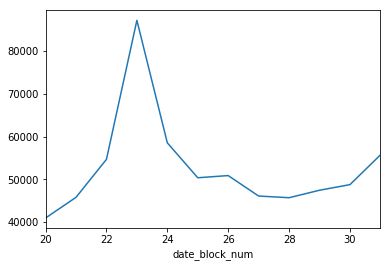

In [13]:
train_split.groupby('date_block_num')['item_cnt_month'].sum().plot()

Secondly, we can see that for different category, the total item_cnt_day is different, indicating that some categories are much more popular then other. <br>
This mean that we can mean encode item_category_id by the item_cnt_month.

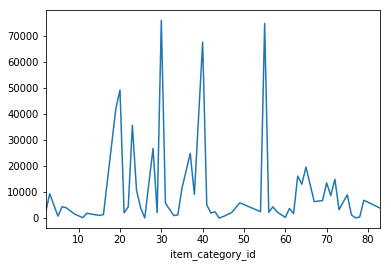

In [14]:
train_split.groupby('item_category_id')['item_cnt_month'].sum().plot()

On the other hand, I can see that the item category names have a lot of common words, for example: category_id 1 to 7 starts with 'Аксессуары' which I think it can let me group the items to bigger categories

In [24]:
item_cat_info['item_category_name'][1:8]

1         Аксессуары - PS2
2         Аксессуары - PS3
3         Аксессуары - PS4
4         Аксессуары - PSP
5      Аксессуары - PSVita
6    Аксессуары - XBOX 360
7    Аксессуары - XBOX ONE
Name: item_category_name, dtype: object

In [19]:
item_cat_info['item_category_name'].str.split(' ').apply(lambda x:x[0])

0             PC
1     Аксессуары
2     Аксессуары
3     Аксессуары
4     Аксессуары
5     Аксессуары
6     Аксессуары
7     Аксессуары
8         Билеты
9       Доставка
10       Игровые
11       Игровые
12       Игровые
13       Игровые
14       Игровые
15       Игровые
16       Игровые
17       Игровые
18          Игры
19          Игры
20          Игры
21          Игры
22          Игры
23          Игры
24          Игры
25          Игры
26          Игры
27          Игры
28          Игры
29          Игры
         ...    
54         Книги
55        Музыка
56        Музыка
57        Музыка
58        Музыка
59        Музыка
60        Музыка
61       Подарки
62       Подарки
63       Подарки
64       Подарки
65       Подарки
66       Подарки
67       Подарки
68       Подарки
69       Подарки
70       Подарки
71       Подарки
72       Подарки
73     Программы
74     Программы
75     Программы
76     Программы
77     Программы
78     Программы
79     Служебные
80     Служебные
81        Чист

# 3.  Feature engineering

Since we believe that if the item_price drops after a period, then the product may be outdated and not popular at all. Which will mean that the future item_cnt_day decrease. So we create features about item_price changes.

In [112]:
train_for_fit = train_split.pivot_table(values='item_cnt_month', index=['item_id','shop_id'], columns=['date_block_num'], aggfunc=np.mean).fillna(0)
train_for_fit.columns = ['past_block_'+ str(12 - i) for i in range(0,12)]
pivoted_item_count = train_for_fit.copy()
rolling_mean3m = pivoted_item_count.rolling(3,axis=1).mean().dropna(axis=1)
rolling_mean3m.columns = ['past_block_3m_mean_'+ str(10 - i) for i in range(0,10)]
train_for_fit = train_for_fit.merge(rolling_mean3m, left_index=True, right_index=True)
rolling_mean6m = pivoted_item_count.rolling(6,axis=1).mean().dropna(axis=1)
rolling_mean6m.columns = ['past_block_6m_mean_'+ str(7 - i) for i in range(0,7)]
train_for_fit = train_for_fit.merge(rolling_mean6m, left_index=True, right_index=True)
rolling_std6m = pivoted_item_count.rolling(6,axis=1).std().dropna(axis=1)
rolling_std6m.columns = ['past_block_6m_std_'+ str(7 - i) for i in range(0,7)]
train_for_fit = train_for_fit.merge(rolling_std6m, left_index=True, right_index=True)
train_for_fit['std_item_cnt_month'] = pivoted_item_count.std(axis=1)
train_for_fit['mean_item_cnt_month'] = train_for_fit.mean(axis=1)
train_for_fit['recent_price'] = train_split.groupby(['item_id','shop_id'])['item_price'].min()

train_for_fit['price_decrease'] = (train_split.groupby(['item_id','shop_id'])['item_price'].min() - train_split.groupby(['item_id','shop_id'])['item_price'].max())
train_for_fit['price_change'] = (train_for_fit['price_decrease'] != 0)

Generate average category month sales for each category

In [113]:
mean_cat_cnt_id = train_split.pivot_table(values='item_cnt_month', index='item_category_id', columns ='date_block_num', aggfunc=np.mean).fillna(0).mean(axis=1)
mean_cat_cnt_id = mean_cat_cnt_id.rename('mean_cat_cnt_id')
train_for_fit = train_for_fit.reset_index()
train_for_fit = train_for_fit.merge(item_info[['item_id','item_category_id']], left_on='item_id', right_on='item_id')
train_for_fit = train_for_fit.merge(mean_cat_cnt_id, left_on='item_category_id', right_index=True)

### Experiment feature

In [114]:
train_for_fit = train_for_fit.merge(pd.get_dummies(train_for_fit['shop_id'], prefix='shop_id').iloc[:,:-1], left_index=True, right_index=True)

# 4.Building Model 

Again, as the data set is a time series, we will use the 20th to 31st month to predict 32nd month as the training period. <br>
Later, we will use 21st to 32nd month to predict 33rd month as the validation period.

For model metric, although in the project, the evaluation is based on RMSE, but I think R2 is much easier to interpret and it is equivalent to R2. Therefore, I will use R2 score to evaluate the model.

In [86]:
X = train_for_fit.drop(['item_category_id'], axis=1)
y = y_train_split
full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
X_train = full_data.drop(['shop_id', 'item_id', 'item_cnt_month'], axis=1)
y_train = full_data['item_cnt_month']
y_train = y_train.clip(0,20)

In [90]:
n_estimators_xgb = np.random.choice(np.arange(10, 100))
max_depth_xgb = np.random.choice(np.arange(1, 11))
reg_lambda_xgb = np.random.choice(np.arange(0, 2, 0.01))
reg_alpha_xgb = np.random.choice(np.arange(0, 2, 0.01))
learning_rate_xgb = np.random.choice(np.arange(0.1, 0.5,0.01))
n_estimators_rf = np.random.choice(np.arange(100, 500))
max_depth_rf = np.random.choice(np.arange(1,11))

print(n_estimators_xgb,
max_depth_xgb,
reg_lambda_xgb,
reg_alpha_xgb,
learning_rate_xgb,
n_estimators_rf,
max_depth_rf)

87 4 0.91 0.62 0.19999999999999996 264 3


In [91]:
# n_estimators_xgb = 47
# max_depth_xgb = 3
# reg_lambda_xgb = 1.71
# reg_alpha_xgb = 1.343
# learning_rate_xgb = 0.14
# n_estimators_rf = 436
# max_depth_rf = 3

In [92]:
model1 = xgb.XGBRegressor(n_estimators=n_estimators_xgb,
                          max_depth=max_depth_xgb,
                          learning_rate=learning_rate_xgb,
                          reg_lambda = reg_lambda_xgb,
                          reg_alpha = reg_alpha_xgb,
                          n_jobs=-1,
                          random_state=9,
                          objective='reg:squarederror')
model1.fit(X_train, y_train)
output1 = model1.predict(X_train)
model2 = RandomForestRegressor(n_estimators=n_estimators_rf,
                               max_depth=max_depth_rf,
                               random_state=9,
                               n_jobs=-1)
model2.fit(X_train, y_train)
output2 = model2.predict(X_train)
input_layer2=np.c_[output1,output2]
model3 = LinearRegression()
model3.fit(input_layer2, y_train)
print('train model r2 score: ' + str(r2_score(y_train, model3.predict(input_layer2))))
print('train model r2 score: ' + str(np.sqrt(mean_squared_error(y_train, model3.predict(input_layer2)))))

C:\Users\starm\Anaconda3\envs\py3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


train model r2 score: 0.7276299124714829
train model r2 score: 1.1434803052857727


Although one may argue that the r2 score here did not count those (item_id, shop_id) pairs that did not appear in both 19th-31st (training X) and 32nd (training y) period , at least we are confident with those appears in both data. We can see whether we have to deal with those appear in y but not in X period later. <br>
At this moment, we can submit the score by filling those which are in test set but not in traning set with 0 zero and see how is the score.

### Validation

In [115]:
y_val_split = train[train['date_block_num'] == 33]
y_val_split = y_val_split.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
y_val_split.columns = ['shop_id', 'item_id', 'item_cnt_month']

val_set = train[(train['date_block_num'] > 20) & (train['date_block_num'] < 33)]
val_split = val_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
val_split = val_split.merge(val_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].min(),
                                left_on=['date_block_num', 'shop_id', 'item_id'],
                                right_index=True)

val_split = val_split.merge(item_info[['item_id', 'item_category_id']], left_on='item_id', right_on='item_id')
val_split.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price', 'item_category_id']

val_for_fit = val_split.pivot_table(values='item_cnt_month', index=['item_id','shop_id'], columns=['date_block_num'], aggfunc=np.mean).fillna(0)
val_for_fit.columns = ['past_block_'+ str(12 - i) for i in range(0,12)]
pivoted_item_count = val_for_fit.copy()
rolling_mean3m = pivoted_item_count.rolling(3,axis=1).mean().dropna(axis=1)
rolling_mean3m.columns = ['past_block_3m_mean_'+ str(10 - i) for i in range(0,10)]
val_for_fit = val_for_fit.merge(rolling_mean3m, left_index=True, right_index=True)
rolling_mean6m = pivoted_item_count.rolling(6,axis=1).mean().dropna(axis=1)
rolling_mean6m.columns = ['past_block_6m_mean_'+ str(7 - i) for i in range(0,7)]
val_for_fit = val_for_fit.merge(rolling_mean6m, left_index=True, right_index=True)
rolling_std6m = pivoted_item_count.rolling(6,axis=1).std().dropna(axis=1)
rolling_std6m.columns = ['past_block_6m_std_'+ str(7 - i) for i in range(0,7)]
val_for_fit = val_for_fit.merge(rolling_std6m, left_index=True, right_index=True)
val_for_fit['std_item_cnt_month'] = pivoted_item_count.std(axis=1)
val_for_fit['mean_item_cnt_month'] = val_for_fit.mean(axis=1)
val_for_fit['recent_price'] = val_split.groupby(['item_id','shop_id'])['item_price'].min()

val_for_fit['price_decrease'] = (val_split.groupby(['item_id','shop_id'])['item_price'].min() - val_split.groupby(['item_id','shop_id'])['item_price'].max())
val_for_fit['price_change'] = (val_for_fit['price_decrease'] != 0)

mean_cat_cnt_id = val_split.pivot_table(values='item_cnt_month', index='item_category_id', columns ='date_block_num', aggfunc=np.mean).fillna(0).mean(axis=1)
mean_cat_cnt_id = mean_cat_cnt_id.rename('mean_cat_cnt_id')
val_for_fit = val_for_fit.reset_index()
val_for_fit = val_for_fit.merge(item_info[['item_id','item_category_id']], left_on='item_id', right_on='item_id')
val_for_fit = val_for_fit.merge(mean_cat_cnt_id, left_on='item_category_id', right_index=True)
val_for_fit = val_for_fit.merge(pd.get_dummies(val_for_fit['shop_id'], prefix='shop_id').iloc[:,:-1], left_index=True, right_index=True)

In [39]:
X = val_for_fit.drop(['item_category_id'], axis=1)
y = y_val_split
full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
X_val = full_data.drop(['shop_id', 'item_id', 'item_cnt_month'], axis=1)
y_val = full_data['item_cnt_month']
y_val = y_val.clip(0,20)

In [ ]:
output1 = model1.predict(X_val)
output2 = model2.predict(X_val)
input_layer2=np.c_[output1,output2]
output3 = model3.predict(input_layer2)
print('val model r2 score: ' + str(r2_score(y_val, model3.predict(input_layer2))))
print('val model r2 score: ' + str(np.sqrt(mean_squared_error(y_val, model3.predict(input_layer2)))))

In [111]:
train_for_fit.columns

Index(['item_id', 'shop_id', 'past_block_12', 'past_block_11', 'past_block_10',
       'past_block_9', 'past_block_8', 'past_block_7', 'past_block_6',
       'past_block_5', 'past_block_4', 'past_block_3', 'past_block_2',
       'past_block_1', 'past_block_3m_mean_10', 'past_block_3m_mean_9',
       'past_block_3m_mean_8', 'past_block_3m_mean_7', 'past_block_3m_mean_6',
       'past_block_3m_mean_5', 'past_block_3m_mean_4', 'past_block_3m_mean_3',
       'past_block_3m_mean_2', 'past_block_3m_mean_1', 'past_block_6m_mean_7',
       'past_block_6m_mean_6', 'past_block_6m_mean_5', 'past_block_6m_mean_4',
       'past_block_6m_mean_3', 'past_block_6m_mean_2', 'past_block_6m_mean_1',
       'past_block_6m_std_7', 'past_block_6m_std_6', 'past_block_6m_std_5',
       'past_block_6m_std_4', 'past_block_6m_std_3', 'past_block_6m_std_2',
       'past_block_6m_std_1', 'std_item_cnt_month', 'mean_item_cnt_month',
       'recent_price', 'price_decrease', 'price_change', 'item_category_id',
       

The model may be a little bit overfitted. However, we can still try to submit the result and see how it goes.

## Refit the model with val set

In [ ]:
model1 = xgb.XGBRegressor(n_estimators=32,
                          max_depth=1,
                          reg_lambda=1.71, 
                          reg_alpha=1.34,
                          learning_rate=0.24,
                          n_jobs = -1,
                          random_state=9,
                          objective='reg:squarederror')
model1.fit(X_val, y_val)
output1 = model1.predict(X_val)
model2 = RandomForestRegressor(n_estimators=341,
                               max_depth=1,
                               random_state=9,
                               n_jobs=-1)
model2.fit(X_val, y_val)
output2 = model2.predict(X_val)
input_layer2=np.c_[output1,output2]
model3 = LinearRegression()
model3.fit(input_layer2, y_val)
print('model r2 score: ' + str(r2_score(y_val, model3.predict(input_layer2))))

# 5. Predicting test set and submit

In [ ]:
test_set = train[(train['date_block_num'] > 21)]
test_split = test_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
test_split = test_split.merge(test_set.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].min(),
                                left_on=['date_block_num', 'shop_id', 'item_id'],
                                right_index=True)

test_split = test_split.merge(item_info[['item_id', 'item_category_id']], left_on='item_id', right_on='item_id')
test_split.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price', 'item_category_id']

test_for_fit = test_split.pivot_table(values='item_cnt_month', index=['item_id','shop_id'], columns=['date_block_num'], aggfunc=np.mean).fillna(0)
test_for_fit.columns = ['past_block_'+ str(12 - i) for i in range(0,12)]
pivoted_item_count = test_for_fit.copy()
rolling_mean3m = pivoted_item_count.rolling(3,axis=1).mean().dropna(axis=1)
rolling_mean3m.columns = ['past_block_3m_mean_'+ str(10 - i) for i in range(0,10)]
test_for_fit = test_for_fit.merge(rolling_mean3m, left_index=True, right_index=True)
rolling_mean6m = pivoted_item_count.rolling(6,axis=1).mean().dropna(axis=1)
rolling_mean6m.columns = ['past_block_6m_mean_'+ str(7 - i) for i in range(0,7)]
test_for_fit = test_for_fit.merge(rolling_mean6m, left_index=True, right_index=True)
test_for_fit['std_item_cnt_month'] = pivoted_item_count.std(axis=1)
test_for_fit['mean_item_cnt_month'] = test_for_fit.mean(axis=1)
test_for_fit['recent_price'] = test_split.groupby(['item_id','shop_id'])['item_price'].min()

test_for_fit['price_decrease'] = (test_split.groupby(['item_id','shop_id'])['item_price'].min() - test_split.groupby(['item_id','shop_id'])['item_price'].max())
test_for_fit['price_change'] = (test_for_fit['price_decrease'] != 0)

mean_cat_cnt_id = test_split.pivot_table(values='item_cnt_month', index='item_category_id', columns ='date_block_num', aggfunc=np.mean).fillna(0).mean(axis=1)
mean_cat_cnt_id = mean_cat_cnt_id.rename('mean_cat_cnt_id')
test_for_fit = test_for_fit.reset_index()
test_for_fit = test_for_fit.merge(item_info[['item_id','item_category_id']], left_on='item_id', right_on='item_id')
test_for_fit = test_for_fit.merge(mean_cat_cnt_id, left_on='item_category_id', right_index=True)

In [ ]:
X = test_for_fit.drop(['item_category_id'], axis=1)
y= test
full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
X_test = full_data.drop(['shop_id', 'item_id', 'ID'], axis=1)

In [ ]:
output1 = model1.predict(X_test)
output2 = model2.predict(X_test)
input_layer2=np.c_[output1,output2]
output3 = model3.predict(input_layer2)
full_data['item_cnt_month'] = output3
full_data['item_cnt_month'] = full_data['item_cnt_month'].clip(0,20)
result = test.merge(full_data[['ID','item_cnt_month']], left_on='ID', right_on='ID', how='outer').fillna(0)
result = result[['ID','item_cnt_month']]
result['item_cnt_month'] = result['item_cnt_month'].round()
result.to_csv('submission.csv', index=False)

In [ ]:
li = pd.Series(model1.feature_importances_, X_train.columns).sort_values()[pd.Series(model1.feature_importances_, X_train.columns).sort_values()>0].index

In [ ]:
pd.Series(model2.feature_importances_, X_train.columns).sort_values()

In [ ]:
    model1 = xgb.XGBRegressor(n_estimators=n_estimators_xgb,
                              max_depth=max_depth_xgb,
                              learning_rate=learning_rate_xgb,
                              reg_lambda = reg_lambda_xgb,
                              reg_alpha = reg_alpha_xgb,
                              n_jobs=-1,
                              random_state=9,
                              objective='reg:squarederror')
    model1.fit(X_train, y_train)

In [116]:
for i in range(1,20):
    print('trial: ' + str(i))
    n_estimators_xgb = np.random.choice(np.arange(10, 100))
    max_depth_xgb = np.random.choice(np.arange(1, 5))
    reg_lambda_xgb = np.random.choice(np.arange(0, 2, 0.01))
    reg_alpha_xgb = np.random.choice(np.arange(0, 2, 0.01))
    learning_rate_xgb = np.random.choice(np.arange(0.1, 0.5,0.01))
    n_estimators_rf = np.random.choice(np.arange(100, 500))
    max_depth_rf = np.random.choice(np.arange(1,11))

    print(n_estimators_xgb,
    max_depth_xgb,
    reg_lambda_xgb,
    reg_alpha_xgb,
    learning_rate_xgb,
    n_estimators_rf,
    max_depth_rf)
    
    X = train_for_fit.drop(['item_category_id'], axis=1)
    y = y_train_split
    full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
    X_train = full_data.drop(['shop_id', 'item_id', 'item_cnt_month'], axis=1)
    y_train = full_data['item_cnt_month']
    y_train = y_train.clip(0,20)

    model1 = xgb.XGBRegressor(n_estimators=n_estimators_xgb,
                              max_depth=max_depth_xgb,
                              learning_rate=learning_rate_xgb,
                              reg_lambda = reg_lambda_xgb,
                              reg_alpha = reg_alpha_xgb,
                              n_jobs=-1,
                              random_state=9,
                              objective='reg:squarederror')
    model1.fit(X_train, y_train)
    output1 = model1.predict(X_train)
    model2 = RandomForestRegressor(n_estimators=n_estimators_rf,
                                   max_depth=max_depth_rf,
                                   random_state=9,
                                   n_jobs=-1)
    model2.fit(X_train, y_train)
    output2 = model2.predict(X_train)
    input_layer2=np.c_[output1,output2]
    model3 = SVR()
    model3.fit(input_layer2, y_train)
    print('train model r2 score: ' + str(r2_score(y_train, model3.predict(input_layer2))))
    print('train model r2 score: ' + str(np.sqrt(mean_squared_error(y_train, model3.predict(input_layer2)))))

    X = val_for_fit.drop(['item_category_id'], axis=1)
    y = y_val_split
    full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
    X_val = full_data.drop(['shop_id', 'item_id', 'item_cnt_month'], axis=1)
    y_val = full_data['item_cnt_month']
    y_val = y_val.clip(0,20)

    output1 = model1.predict(X_val)
    output2 = model2.predict(X_val)
    input_layer2=np.c_[output1,output2]
    output3 = model3.predict(input_layer2)
    print('val model r2 score: ' + str(r2_score(y_val, model3.predict(input_layer2))))
    print('val model r2 score: ' + str(np.sqrt(mean_squared_error(y_val, model3.predict(input_layer2)))))

trial: 1
95 4 0.59 0.6900000000000001 0.24999999999999992 174 3


C:\Users\starm\Anaconda3\envs\py3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\starm\Anaconda3\envs\py3.6\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train model r2 score: 0.734542928411225
train model r2 score: 1.1288757226949733
val model r2 score: 0.3200648302132115
val model r2 score: 1.781952223509592
trial: 2
58 1 1.28 1.23 0.3199999999999999 174 8


C:\Users\starm\Anaconda3\envs\py3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\starm\Anaconda3\envs\py3.6\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train model r2 score: 0.7016968319498895
train model r2 score: 1.196679679906745
val model r2 score: 0.2446985766266916


KeyboardInterrupt: 

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dense, Dropout

In [ ]:
model4 = Sequential()
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(16, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(4, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(2, activation='relu'))
model4.add(Dense(1, activation='linear'))
model4.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model4.fit(X_train[list(li)].values, y_train.values, epochs=70, batch_size=8128, validation_data=(X_val[list(li)].values, y_val.values))

In [ ]:
mean_squared_error(y_val, model4.predict(X_val).reshape(-1))

In [ ]:
import catboost

In [ ]:
model4 = catboost.CatBoostRegressor(iterations=121)

In [ ]:
model4.fit(X_train,y_train,cat_features = ['item_category_id', 'shop_id', 'item_id'], eval_set=(X_val,y_val))

In [ ]:
X = test_for_fit
y= test
full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
X_test = full_data.drop(['ID'], axis=1)

In [ ]:
full_data['item_cnt_month'] = model4.predict(X_test)
full_data['item_cnt_month'] = full_data['item_cnt_month'].clip(0,20)
result = test.merge(full_data[['ID','item_cnt_month']], left_on='ID', right_on='ID', how='outer').fillna(0)
result = result[['ID','item_cnt_month']]
result['item_cnt_month'] = result['item_cnt_month'].round()
result.to_csv('submission.csv', index=False)

In [ ]:
pd.Series(model4.feature_importances_, X_test.columns).sort_values()

In [ ]:
X = train_for_fit
y = y_train_split
full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
X_train = full_data.drop(['item_cnt_month'], axis=1)
y_train = full_data['item_cnt_month']
y_train = y_train.clip(0,20)

In [ ]:
X = val_for_fit
y = y_val_split
full_data = X.merge(y, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'])
X_val = full_data.drop([ 'item_cnt_month'], axis=1)
y_val = full_data['item_cnt_month']
y_val = y_val.clip(0,20)

In [ ]:
X['item_category_id'].value_counts().shape

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
scalar = MinMaxScaler()

In [ ]:
transed = scalar.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
model5 = LogisticRegression()

In [46]:
mind_child_sample=np.random.choice(np.arange(0.01, 0.3, 0.01))

In [ ]:
model10.fit()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
mean_squared_error(y_val, model10.predict(X_val).astype(int))

2.7244076583746417